In [2]:
# Neural Bayes-MIM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torch.utils.data as utils
from torch.nn import Parameter
import torch.autograd as autograd
from torch.autograd import Variable
import math
import os

import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = ':'
matplotlib.rcParams['grid.linewidth'] = 0.5

from matplotlib import pyplot
from argparse import Namespace
import pickle as pkl
import tqdm
from tqdm import tnrange, tqdm_notebook

torch.manual_seed(0)

NUM_WORKERS = 0

use_cuda=False
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
class MLPNet(nn.Module):
    def __init__(self, dim_inp=None, dim_out=None, bn=True):
        super(MLPNet, self).__init__()
        self.dim_inp = dim_inp
        relu = nn.ReLU()
        
        self.fc1 = nn.Linear(dim_inp, 500)
        self.bn1=nn.BatchNorm1d(500) if bn else nn.Sequential()
        self.fc2 = nn.Linear(500, 500)
        self.bn2=nn.BatchNorm1d(500) if bn else nn.Sequential()
        self.fc3 = nn.Linear(500, dim_out)
        self.bn3= nn.BatchNorm1d(dim_out) if bn else nn.Sequential() # 
        
    def forward(self, x, all=False):
        hid={}
        x = x.view(-1, self.dim_inp)
        x = self.fc1(x)
        hid['0'] = x
        x = F.relu(self.bn1(x))
        x=self.fc2(x)
        hid['1'] = x
        x = F.relu(self.bn2(x))
        x=self.fc3(x)
        hid['2'] = x
        x = F.relu(self.bn3(x))
        if all:
            return hid
        return x
    
def get_noise(x):
    sz = x.size()
    x = x.view(x.size(0), -1)
    mn = x.mean(dim=0, keepdim=True)
    x = x-mn
    eps = torch.randint(0,2, (x.size(0), x.size(0))).cuda(). type('torch.cuda.FloatTensor')
    noise = torch.mm(x.t(), eps).t()
    norm = torch.norm(noise, dim=1, keepdim=True)
    assert not np.any(norm.detach().cpu().numpy()==0), '0 norm {}'.format(torch.min(norm))
    noise = noise/norm
    return noise.view(sz)

def plot_w(w, n1 = 10,n2=10, save=False):
    fig, axes = plt.subplots(n1,n2)
    # use global min / max to ensure all weights are shown on the same scale
    vmin, vmax = w.min(), w.max()
    for coef, ax in zip(w, axes.ravel()):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                   vmax=.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())
    if save:
        plt.savefig('plots/mnist_filters.jpg')
    else:
        plt.show()

In [4]:
# get dataset
def get_dataset(BS):
    trans = ([ transforms.ToTensor(), 
              transforms.Normalize((0.5,), (0.5,))
             ]) 
    trans = transforms.Compose(trans)
    train_set = torchvision.datasets.MNIST(root='datasets/', train=True, transform=trans, download=True)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True,
                                              num_workers=NUM_WORKERS, pin_memory=True)


    test_set = torchvision.datasets.MNIST(root='datasets/', train=False, transform=trans)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=False, num_workers=NUM_WORKERS)

    nb_classes = 10
    dim_inp=28*28
    return trainloader, testloader, nb_classes, dim_inp

In [8]:
def get_loss(Lx,config=None):
    EPSILON=1e-7
    CE, gp=0,0
    assert isinstance(Lx, dict)
    loss = 0
    N=0
    for key in Lx.keys():
        N+=1
        Lx_ = Lx[key]
        Lx_ = nn.Softmax(dim=1)(Lx_)
        ELx = torch.mean(Lx_, dim=0,keepdim=True)# 

#       CE_ =  (ELx* torch.log(ELx.detach()) ).sum(dim=1).mean() # Neural Bayes-MIM-v1
        CE_ = - ( ((1./ELx.size(1))*torch.log(ELx) + (1.-1./ELx.size(1))*torch.log(1.-ELx))).sum(1).mean() # v2
        CE += CE_
        loss += -(Lx_* torch.log(Lx_.detach()+EPSILON) ).sum(dim=1).mean() + (1.+ config.alpha)* CE_
    return loss/N, CE/N

def train(config):
    flag=0
    global trainloader, optimizer, model
    model.train()
    
    total_loss, total_grad_pen = 0, 0
    loss2=0
    
    tot_iters = len(trainloader)
    for batch_idx in (range(tot_iters)):
        optimizer.zero_grad() 
        inputs, targets = next(iter(trainloader)) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        inputs = inputs.view(inputs.size(0), -1)
        b_x0 = Variable(inputs)
        noise =  np.random.randn()* get_noise(b_x0)
        b_x = b_x0 + 0.1*noise


        Lx0 = (model(b_x0, config.all))
        Lx = (model(b_x, config.all))
        loss, _=get_loss(Lx0, config)
        L = loss

        if math.isnan(L.item()):
            flag=1
            print('NaN encountered, exiting training.')
            break
            exit()
            hbj
        L.backward()  

        total_loss += loss.item()

        beta = config.beta
        grad_penalty=0
        if config.beta>0:
            Lx0 = (model(b_x0))
            Lx = (model(b_x))
            grad_penalty = ( ((Lx-Lx0)**2).sum(dim=1)/((b_x-b_x0)**2).sum(dim=1) ).mean()
            (config.beta* grad_penalty).backward()  
            total_grad_pen += grad_penalty.item()
        optimizer.step()
        optimizer.zero_grad() 
    return total_loss/(batch_idx+1), total_grad_pen/(batch_idx+1),flag

In [17]:
config=Namespace()
config.epsilon=1e-7
config.LEARNING_RATE = 0.001
config.WD = 0.0000
config.EPOCHS = 50
config.dim_inp, config.dim_out = 784, 100
config.beta = 4
config.alpha =4
config.all=True
config.bn=True

trainloader, testloader, nb_classes, dim_inp = get_dataset(BS=500)
model = MLPNet(dim_inp = config.dim_inp, dim_out=config.dim_out, bn=config.bn).cuda()
params = list(model.parameters())

optimizer = torch.optim.Adam(params, lr=config.LEARNING_RATE, weight_decay=config.WD) 
loss_list, grad_loss_list = [], []
epoch=0


In [18]:
while epoch<config.EPOCHS:
    epoch+=1
    loss, grad_loss,flag = train(config)
    loss_list.append(loss)
    grad_loss_list.append(grad_loss)
    print('Epoch {}/{} | loss {:.3f} | grad_loss {:.3f}'.format(epoch, config.EPOCHS, loss, grad_loss))
    if flag==1:
        break

Epoch 1/50 | loss 38.761 | grad_loss 0.034
Epoch 2/50 | loss 38.099 | grad_loss 0.011
Epoch 3/50 | loss 37.660 | grad_loss 0.008
Epoch 4/50 | loss 37.281 | grad_loss 0.007
Epoch 5/50 | loss 36.916 | grad_loss 0.007
Epoch 6/50 | loss 36.586 | grad_loss 0.006
Epoch 7/50 | loss 36.300 | grad_loss 0.004
Epoch 8/50 | loss 36.101 | grad_loss 0.003
Epoch 9/50 | loss 35.961 | grad_loss 0.002
Epoch 10/50 | loss 35.851 | grad_loss 0.001
Epoch 11/50 | loss 35.780 | grad_loss 0.001
Epoch 12/50 | loss 35.729 | grad_loss 0.000
Epoch 13/50 | loss 35.683 | grad_loss 0.000
Epoch 14/50 | loss 35.652 | grad_loss 0.000
Epoch 15/50 | loss 35.613 | grad_loss 0.000
Epoch 16/50 | loss 35.581 | grad_loss 0.000
Epoch 17/50 | loss 35.571 | grad_loss 0.000
Epoch 18/50 | loss 35.536 | grad_loss 0.000
Epoch 19/50 | loss 35.530 | grad_loss 0.000
Epoch 20/50 | loss 35.516 | grad_loss 0.000
Epoch 21/50 | loss 35.504 | grad_loss 0.000
Epoch 22/50 | loss 35.486 | grad_loss 0.000
Epoch 23/50 | loss 35.484 | grad_loss 0.0

In [19]:
model_=model
for m in model_.modules():
    if isinstance(m, nn.Linear):
        w = m.weight
        break
w = w.data.cpu().numpy()
print(w.shape)

(500, 784)


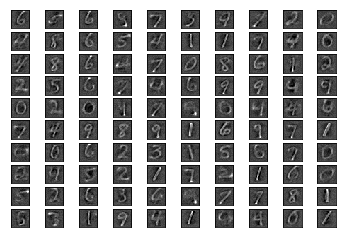

In [20]:
plot_w(w, n1 = 10,n2=10, save=False)